In [1]:
%%capture

#!pip install numpy==1.17.5
#!pip install -U numpy==1.11.0
!pip3 install numpy==1.17.4

import numpy as np
import pandas as pd 
from tqdm import tqdm

from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

!pip install fastai --upgrade

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from fastai.vision.all import *

In [2]:
coord_df = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
coord_df.head(3)

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180


uint8
(380, 676, 3)
473.9826339 172.8523166 602.1389291 231.0505148


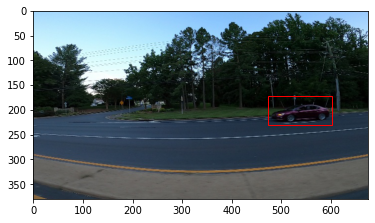

In [3]:
plt_image = image.imread('../input/car-object-detection/data/training_images/vid_4_10480.jpg')

print(plt_image.dtype)
print(plt_image.shape)

fig, ax = plt.subplots()

ax.imshow(plt_image)

xmin = float(coord_df[coord_df["image"] == "vid_4_10480.jpg"]['xmin'])
ymin = float(coord_df[coord_df["image"] == "vid_4_10480.jpg"]['ymin'])
xmax = float(coord_df[coord_df["image"] == "vid_4_10480.jpg"]['xmax'])
ymax = float(coord_df[coord_df["image"] == "vid_4_10480.jpg"]['ymax'])

print(xmin, ymin, xmax, ymax)

rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

ax.add_patch(rect)

plt.show()

uint8
(380, 676, 3)
473.9826339 172.8523166 602.1389291 231.0505148


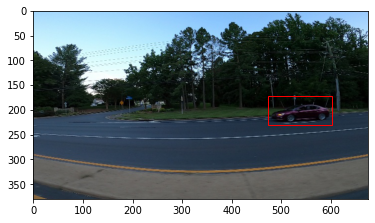

In [4]:
file_name = coord_df.iloc[10]['image']
plt_image = image.imread('../input/car-object-detection/data/training_images/'+file_name)
print(plt_image.dtype)
print(plt_image.shape)
fig, ax = plt.subplots()
ax.imshow(plt_image)
xmin = float(coord_df[coord_df["image"] == file_name]['xmin'])
ymin = float(coord_df[coord_df["image"] == file_name]['ymin'])
xmax = float(coord_df[coord_df["image"] == file_name]['xmax'])
ymax = float(coord_df[coord_df["image"] == file_name]['ymax'])
print(xmin, ymin, xmax, ymax)
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [5]:
class CarDetectionDataset(torch.utils.data.Dataset):  
    def __init__(self, images_path, df, std=False):
        super(CarDetectionDataset, self).__init__()
        self.images_path = glob.glob(images_path+"*")
        self.df = df
        self.std = std
        self.bbox_cols = ['xmin', 'ymin', 'xmax', 'ymax']
        
    def __len__(self):
        return len(self.images_path)  

    def __getitem__(self, idx):
        file_path = self.images_path[idx]
        
        rows = self.df[self.df["image"] == file_path[51:]]
        bbox = rows[self.bbox_cols].values
        
        img = cv2.imread(str(file_path), cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        bbox = np.array(bbox)
        
        areas = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
        bbox = torch.from_numpy(bbox) 
        bbox = torch.as_tensor(bbox, dtype=torch.int64)
        
        if self.std:
            img = img/255.0
            
        img = img.reshape(3, img.shape[0], img.shape[1])
        target = {}
        
        labels = torch.ones((bbox.shape[0]), dtype=torch.int64)            
        
        image_id = torch.tensor([idx])
        
        areas = torch.as_tensor(areas.astype(np.float), dtype=torch.double)
        iscrowd = torch.zeros((bbox.shape[0],))
        
        target["boxes"] = bbox
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd
        target["image_id"] = image_id    
        img = torch.from_numpy(img)
        img = torch.as_tensor(img, dtype=torch.double)
        
        return img, target

torch.Size([380, 676, 3]) tensor([[125, 187, 266, 236],
        [614, 178, 676, 231]]) tensor([1, 1])


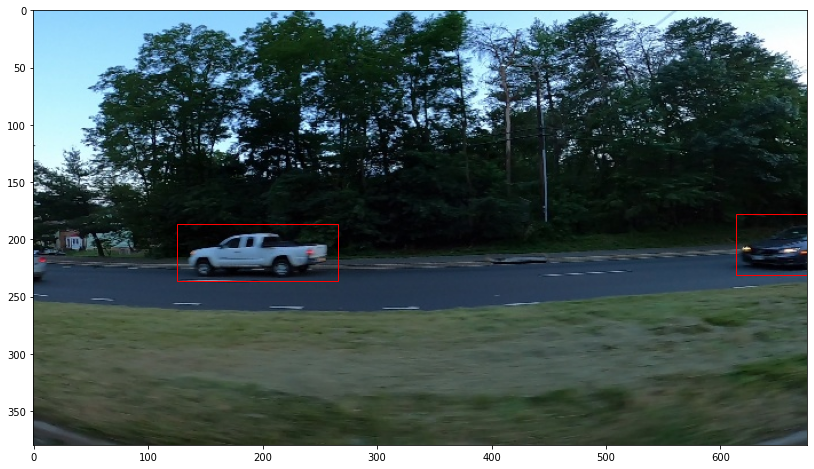

In [6]:
dataset = CarDetectionDataset("../input/car-object-detection/data/training_images/", coord_df)
img, target = dataset.__getitem__(300)
img = img.reshape(img.shape[1], img.shape[2], 3)
img = torch.as_tensor(img, dtype=torch.int)
print(img.shape, target["boxes"], target["labels"])

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(img)
rect = patches.Rectangle((125, 187), 266-125, 236-187, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((614, 178), 676-614, 231-178, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = CarDetectionDataset("../input/car-object-detection/data/training_images/", coord_df, std=True)

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-300])
val_dataset = torch.utils.data.Subset(dataset, indices[-300:])

# define training and validation data loaders
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=8, shuffle=True, num_workers=0,
        collate_fn = collate_fn)

val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False, num_workers=0,
        collate_fn = collate_fn)

In [8]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("Device:", device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print("Device:", device)

Device: cuda Tesla P100-PCIE-16GB


In [9]:
%%sh
if [ ! -d "output/vision" ]; then
    git clone https://github.com/pytorch/vision.git output/vision
else
    echo "output/vision already cloned"
fi

cp output/vision/references/detection/utils.py .
cp output/vision/references/detection/transforms.py .
cp output/vision/references/detection/coco_eval.py .
cp output/vision/references/detection/engine.py .
cp output/vision/references/detection/coco_utils.py .

Cloning into 'output/vision'...


In [10]:
%%capture
!pip3 install pycocotools
!pip3 install -U scikit-image
!pip3 install -U cython 

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

fasterRCNN_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = fasterRCNN_model.roi_heads.box_predictor.cls_score.in_features
fasterRCNN_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

In [12]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
from engine import train_one_epoch, evaluate
import time

train_loss_hist = LossAverager()

EPOCHS = 30

fasterRCNN_model.double()
fasterRCNN_model.to(device)

params = [p for p in fasterRCNN_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005)#, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)


for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    tick = time.time()
    fasterRCNN_model.train()
    train_loss_hist.reset()
    
    for images, targets in tqdm(train_dataloader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]
        
        loss_dict = fasterRCNN_model(images, targets)
        
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        
        train_loss_hist.update(lossValue,bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
        lr_scheduler.step(totalLoss)
        
    print(f"Train loss: {train_loss_hist.avg}")
    fasterRCNN_model.eval()
    
    cumulative_jaccard= []
    
    for images, targets in tqdm(val_dataloader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        outputs = fasterRCNN_model(images)
        
        images = torch.as_tensor(images.astype(np.float), dtype=torch.double)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]        
        
        NMS = []
        for a, b in zip(outputs[0]['scores'], outputs[0]['boxes']):
            if a >= 0.3:
                box = []
                for coor in b:
                    box.append(int(coor))
                NMS.append(box)
        
        NMS = np.array(NMS, dtype=np.float32)
        NMS = torch.from_numpy(NMS) 
        NMS = torch.as_tensor(NMS, dtype=torch.float32)
        
        ious = []
        for target, output in zip(targets, outputs):
            pred_boxes = NMS
            groung_truths = target["boxes"].detach()
            ious.append(torchvision.ops.box_iou(pred_boxes, groung_truths))
        
        
#sample = images
#images = torch.tensor(images)
#images = images.permute(2,0,1)
#images = torch.unsqueeze(images, 0)
#images = images.to(cpu_device)
#fasterRCNN_model.eval()

#fasterRCNN_model.to(cpu_device)
#outputs = fasterRCNN_model(images)
#outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
#boxes = outputs[0]["boxes"].detach().numpy().astype(np.int32)
    
    #!rm -rf ./output/
    #evaluate(fasterRCNN_model, val_dataloader, device=device)

Epoch 1/30


100%|██████████| 88/88 [00:49<00:00,  1.79it/s]


Train loss: 0.09142669334599647
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0372 (0.0372)  evaluator_time: 0.0003 (0.0003)  time: 0.0460  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0376 (0.0368)  evaluator_time: 0.0004 (0.0005)  time: 0.0474  data: 0.0082  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0366 (0.0367)  evaluator_time: 0.0003 (0.0004)  time: 0.0463  data: 0.0074  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0378 (0.0366)  evaluator_time: 0.0003 (0.0004)  time: 0.0463  data: 0.0073  max mem: 10050
Test: Total time: 0:00:13 (0.0463 s / it)
Averaged stats: model_time: 0.0378 (0.0366)  evaluator_time: 0.0003 (0.0004)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:49<00:00,  1.79it/s]


Train loss: 0.08186451731659064
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0374 (0.0374)  evaluator_time: 0.0003 (0.0003)  time: 0.0463  data: 0.0069  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0372 (0.0366)  evaluator_time: 0.0003 (0.0004)  time: 0.0457  data: 0.0070  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0371 (0.0368)  evaluator_time: 0.0003 (0.0004)  time: 0.0460  data: 0.0070  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0374 (0.0369)  evaluator_time: 0.0003 (0.0004)  time: 0.0468  data: 0.0073  max mem: 10050
Test: Total time: 0:00:13 (0.0461 s / it)
Averaged stats: model_time: 0.0374 (0.0369)  evaluator_time: 0.0003 (0.0004)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:49<00:00,  1.78it/s]


Train loss: 0.08848279014805335
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0339 (0.0339)  evaluator_time: 0.0003 (0.0003)  time: 0.0428  data: 0.0069  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0343 (0.0344)  evaluator_time: 0.0004 (0.0004)  time: 0.0457  data: 0.0082  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0340 (0.0346)  evaluator_time: 0.0003 (0.0004)  time: 0.0439  data: 0.0071  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0346 (0.0345)  evaluator_time: 0.0003 (0.0004)  time: 0.0438  data: 0.0070  max mem: 10050
Test: Total time: 0:00:13 (0.0437 s / it)
Averaged stats: model_time: 0.0346 (0.0345)  evaluator_time: 0.0003 (0.0004)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:49<00:00,  1.79it/s]


Train loss: 0.09202194089586549
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0371 (0.0371)  evaluator_time: 0.0004 (0.0004)  time: 0.0459  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0382 (0.0384)  evaluator_time: 0.0003 (0.0004)  time: 0.0474  data: 0.0071  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0382 (0.0384)  evaluator_time: 0.0003 (0.0004)  time: 0.0471  data: 0.0071  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0386 (0.0385)  evaluator_time: 0.0003 (0.0004)  time: 0.0478  data: 0.0072  max mem: 10050
Test: Total time: 0:00:14 (0.0479 s / it)
Averaged stats: model_time: 0.0386 (0.0385)  evaluator_time: 0.0003 (0.0004)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:48<00:00,  1.80it/s]


Train loss: 0.09477066936430749
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0356 (0.0356)  evaluator_time: 0.0004 (0.0004)  time: 0.0456  data: 0.0078  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0374 (0.0373)  evaluator_time: 0.0003 (0.0004)  time: 0.0474  data: 0.0078  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0379 (0.0377)  evaluator_time: 0.0003 (0.0004)  time: 0.0462  data: 0.0069  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0379 (0.0376)  evaluator_time: 0.0003 (0.0004)  time: 0.0468  data: 0.0070  max mem: 10050
Test: Total time: 0:00:14 (0.0469 s / it)
Averaged stats: model_time: 0.0379 (0.0376)  evaluator_time: 0.0003 (0.0004)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:48<00:00,  1.80it/s]


Train loss: 0.09803693495120015
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0334 (0.0334)  evaluator_time: 0.0004 (0.0004)  time: 0.0423  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0333 (0.0340)  evaluator_time: 0.0003 (0.0004)  time: 0.0426  data: 0.0069  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0339 (0.0342)  evaluator_time: 0.0003 (0.0004)  time: 0.0433  data: 0.0072  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0362 (0.0344)  evaluator_time: 0.0005 (0.0004)  time: 0.0481  data: 0.0102  max mem: 10050
Test: Total time: 0:00:13 (0.0441 s / it)
Averaged stats: model_time: 0.0362 (0.0344)  evaluator_time: 0.0005 (0.0004)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:48<00:00,  1.82it/s]


Train loss: 0.10144697730008889
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0371 (0.0371)  evaluator_time: 0.0004 (0.0004)  time: 0.0459  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0398 (0.0393)  evaluator_time: 0.0003 (0.0007)  time: 0.0487  data: 0.0071  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0405 (0.0397)  evaluator_time: 0.0004 (0.0008)  time: 0.0524  data: 0.0097  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0405 (0.0396)  evaluator_time: 0.0003 (0.0008)  time: 0.0501  data: 0.0083  max mem: 10050
Test: Total time: 0:00:14 (0.0496 s / it)
Averaged stats: model_time: 0.0405 (0.0396)  evaluator_time: 0.0003 (0.0008)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:48<00:00,  1.83it/s]


Train loss: 0.10421748291978918
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0331 (0.0331)  evaluator_time: 0.0003 (0.0003)  time: 0.0420  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0326 (0.0335)  evaluator_time: 0.0003 (0.0004)  time: 0.0422  data: 0.0071  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0331 (0.0337)  evaluator_time: 0.0003 (0.0004)  time: 0.0420  data: 0.0069  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0339 (0.0336)  evaluator_time: 0.0003 (0.0004)  time: 0.0426  data: 0.0070  max mem: 10050
Test: Total time: 0:00:12 (0.0431 s / it)
Averaged stats: model_time: 0.0339 (0.0336)  evaluator_time: 0.0003 (0.0004)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:47<00:00,  1.85it/s]


Train loss: 0.10631082656052875
creating index...
index created!
Test:  [  0/300]  eta: 0:00:15  model_time: 0.0393 (0.0393)  evaluator_time: 0.0005 (0.0005)  time: 0.0521  data: 0.0105  max mem: 10050
Test:  [100/300]  eta: 0:00:10  model_time: 0.0405 (0.0409)  evaluator_time: 0.0005 (0.0023)  time: 0.0508  data: 0.0071  max mem: 10050
Test:  [200/300]  eta: 0:00:05  model_time: 0.0406 (0.0406)  evaluator_time: 0.0008 (0.0023)  time: 0.0504  data: 0.0074  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0410 (0.0406)  evaluator_time: 0.0008 (0.0023)  time: 0.0509  data: 0.0072  max mem: 10050
Test: Total time: 0:00:15 (0.0522 s / it)
Averaged stats: model_time: 0.0410 (0.0406)  evaluator_time: 0.0008 (0.0023)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:47<00:00,  1.86it/s]


Train loss: 0.10947385689092964
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0360 (0.0360)  evaluator_time: 0.0003 (0.0003)  time: 0.0455  data: 0.0073  max mem: 10050
Test:  [100/300]  eta: 0:00:10  model_time: 0.0411 (0.0401)  evaluator_time: 0.0010 (0.0032)  time: 0.0520  data: 0.0073  max mem: 10050
Test:  [200/300]  eta: 0:00:05  model_time: 0.0411 (0.0402)  evaluator_time: 0.0010 (0.0033)  time: 0.0506  data: 0.0072  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0411 (0.0402)  evaluator_time: 0.0012 (0.0034)  time: 0.0528  data: 0.0075  max mem: 10050
Test: Total time: 0:00:15 (0.0527 s / it)
Averaged stats: model_time: 0.0411 (0.0402)  evaluator_time: 0.0012 (0.0034)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:47<00:00,  1.86it/s]


Train loss: 0.10784120296432385
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0339 (0.0339)  evaluator_time: 0.0004 (0.0004)  time: 0.0428  data: 0.0069  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0368 (0.0370)  evaluator_time: 0.0006 (0.0020)  time: 0.0476  data: 0.0076  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0367 (0.0370)  evaluator_time: 0.0003 (0.0020)  time: 0.0468  data: 0.0073  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0395 (0.0372)  evaluator_time: 0.0006 (0.0019)  time: 0.0517  data: 0.0091  max mem: 10050
Test: Total time: 0:00:14 (0.0483 s / it)
Averaged stats: model_time: 0.0395 (0.0372)  evaluator_time: 0.0006 (0.0019)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:47<00:00,  1.87it/s]


Train loss: 0.11311348538281364
creating index...
index created!
Test:  [  0/300]  eta: 0:00:14  model_time: 0.0349 (0.0349)  evaluator_time: 0.0005 (0.0005)  time: 0.0492  data: 0.0121  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0312 (0.0322)  evaluator_time: 0.0003 (0.0006)  time: 0.0410  data: 0.0071  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0313 (0.0323)  evaluator_time: 0.0003 (0.0007)  time: 0.0414  data: 0.0076  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0326 (0.0324)  evaluator_time: 0.0003 (0.0007)  time: 0.0420  data: 0.0074  max mem: 10050
Test: Total time: 0:00:12 (0.0420 s / it)
Averaged stats: model_time: 0.0326 (0.0324)  evaluator_time: 0.0003 (0.0007)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:46<00:00,  1.88it/s]


Train loss: 0.1156791796651626
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0330 (0.0330)  evaluator_time: 0.0003 (0.0003)  time: 0.0419  data: 0.0069  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0348 (0.0355)  evaluator_time: 0.0003 (0.0013)  time: 0.0454  data: 0.0072  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0352 (0.0357)  evaluator_time: 0.0003 (0.0014)  time: 0.0450  data: 0.0073  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0395 (0.0361)  evaluator_time: 0.0006 (0.0014)  time: 0.0539  data: 0.0116  max mem: 10050
Test: Total time: 0:00:14 (0.0468 s / it)
Averaged stats: model_time: 0.0395 (0.0361)  evaluator_time: 0.0006 (0.0014)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75     

100%|██████████| 88/88 [00:46<00:00,  1.89it/s]


Train loss: 0.11798911094145809
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0333 (0.0333)  evaluator_time: 0.0003 (0.0003)  time: 0.0422  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0326 (0.0334)  evaluator_time: 0.0003 (0.0009)  time: 0.0426  data: 0.0072  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0335 (0.0336)  evaluator_time: 0.0003 (0.0010)  time: 0.0428  data: 0.0072  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0339 (0.0338)  evaluator_time: 0.0005 (0.0010)  time: 0.0435  data: 0.0072  max mem: 10050
Test: Total time: 0:00:13 (0.0441 s / it)
Averaged stats: model_time: 0.0339 (0.0338)  evaluator_time: 0.0005 (0.0010)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:46<00:00,  1.89it/s]


Train loss: 0.12068290863211263
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0330 (0.0330)  evaluator_time: 0.0004 (0.0004)  time: 0.0418  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0343 (0.0351)  evaluator_time: 0.0006 (0.0021)  time: 0.0460  data: 0.0073  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0347 (0.0362)  evaluator_time: 0.0006 (0.0023)  time: 0.0452  data: 0.0074  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0358 (0.0360)  evaluator_time: 0.0006 (0.0023)  time: 0.0469  data: 0.0073  max mem: 10050
Test: Total time: 0:00:14 (0.0477 s / it)
Averaged stats: model_time: 0.0358 (0.0360)  evaluator_time: 0.0006 (0.0023)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:46<00:00,  1.90it/s]


Train loss: 0.1236093431043887
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0329 (0.0329)  evaluator_time: 0.0003 (0.0003)  time: 0.0419  data: 0.0069  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0319 (0.0335)  evaluator_time: 0.0003 (0.0012)  time: 0.0422  data: 0.0071  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0326 (0.0332)  evaluator_time: 0.0003 (0.0012)  time: 0.0417  data: 0.0071  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0331 (0.0332)  evaluator_time: 0.0005 (0.0011)  time: 0.0434  data: 0.0074  max mem: 10050
Test: Total time: 0:00:13 (0.0435 s / it)
Averaged stats: model_time: 0.0331 (0.0332)  evaluator_time: 0.0005 (0.0011)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.75     

100%|██████████| 88/88 [00:46<00:00,  1.90it/s]


Train loss: 0.12435607143557144
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0329 (0.0329)  evaluator_time: 0.0004 (0.0004)  time: 0.0420  data: 0.0070  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0333 (0.0341)  evaluator_time: 0.0003 (0.0016)  time: 0.0439  data: 0.0073  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0339 (0.0342)  evaluator_time: 0.0003 (0.0016)  time: 0.0430  data: 0.0071  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0346 (0.0342)  evaluator_time: 0.0005 (0.0015)  time: 0.0484  data: 0.0096  max mem: 10050
Test: Total time: 0:00:13 (0.0448 s / it)
Averaged stats: model_time: 0.0346 (0.0342)  evaluator_time: 0.0005 (0.0015)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:46<00:00,  1.90it/s]


Train loss: 0.1230592730141842
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0340 (0.0340)  evaluator_time: 0.0005 (0.0005)  time: 0.0464  data: 0.0101  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0307 (0.0317)  evaluator_time: 0.0003 (0.0007)  time: 0.0405  data: 0.0069  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0309 (0.0317)  evaluator_time: 0.0003 (0.0008)  time: 0.0405  data: 0.0071  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0319 (0.0318)  evaluator_time: 0.0005 (0.0008)  time: 0.0414  data: 0.0072  max mem: 10050
Test: Total time: 0:00:12 (0.0415 s / it)
Averaged stats: model_time: 0.0319 (0.0318)  evaluator_time: 0.0005 (0.0008)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.75     

100%|██████████| 88/88 [00:45<00:00,  1.92it/s]


Train loss: 0.13284189566769675
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0332 (0.0332)  evaluator_time: 0.0004 (0.0004)  time: 0.0435  data: 0.0083  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0314 (0.0326)  evaluator_time: 0.0003 (0.0010)  time: 0.0417  data: 0.0070  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0320 (0.0327)  evaluator_time: 0.0003 (0.0010)  time: 0.0413  data: 0.0069  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0326 (0.0328)  evaluator_time: 0.0005 (0.0010)  time: 0.0426  data: 0.0071  max mem: 10050
Test: Total time: 0:00:12 (0.0427 s / it)
Averaged stats: model_time: 0.0326 (0.0328)  evaluator_time: 0.0005 (0.0010)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:45<00:00,  1.92it/s]


Train loss: 0.1321892598219072
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0325 (0.0325)  evaluator_time: 0.0003 (0.0003)  time: 0.0416  data: 0.0071  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0313 (0.0322)  evaluator_time: 0.0003 (0.0009)  time: 0.0412  data: 0.0069  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0321 (0.0323)  evaluator_time: 0.0003 (0.0010)  time: 0.0412  data: 0.0070  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0326 (0.0324)  evaluator_time: 0.0005 (0.0010)  time: 0.0423  data: 0.0073  max mem: 10050
Test: Total time: 0:00:12 (0.0423 s / it)
Averaged stats: model_time: 0.0326 (0.0324)  evaluator_time: 0.0005 (0.0010)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.75     

100%|██████████| 88/88 [00:45<00:00,  1.92it/s]


Train loss: 0.13288663107484297
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0330 (0.0330)  evaluator_time: 0.0003 (0.0003)  time: 0.0419  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0320 (0.0330)  evaluator_time: 0.0003 (0.0013)  time: 0.0424  data: 0.0070  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0332 (0.0332)  evaluator_time: 0.0003 (0.0014)  time: 0.0425  data: 0.0072  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0333 (0.0333)  evaluator_time: 0.0005 (0.0013)  time: 0.0439  data: 0.0073  max mem: 10050
Test: Total time: 0:00:13 (0.0436 s / it)
Averaged stats: model_time: 0.0333 (0.0333)  evaluator_time: 0.0005 (0.0013)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:45<00:00,  1.92it/s]


Train loss: 0.13404538862623658
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0329 (0.0329)  evaluator_time: 0.0004 (0.0004)  time: 0.0424  data: 0.0072  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0307 (0.0317)  evaluator_time: 0.0003 (0.0008)  time: 0.0407  data: 0.0071  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0308 (0.0317)  evaluator_time: 0.0003 (0.0008)  time: 0.0403  data: 0.0071  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0312 (0.0319)  evaluator_time: 0.0005 (0.0009)  time: 0.0414  data: 0.0072  max mem: 10050
Test: Total time: 0:00:12 (0.0416 s / it)
Averaged stats: model_time: 0.0312 (0.0319)  evaluator_time: 0.0005 (0.0009)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:45<00:00,  1.94it/s]


Train loss: 0.1430312589021549
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0354 (0.0354)  evaluator_time: 0.0012 (0.0012)  time: 0.0450  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0345 (0.0350)  evaluator_time: 0.0008 (0.0022)  time: 0.0456  data: 0.0072  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0363 (0.0352)  evaluator_time: 0.0009 (0.0023)  time: 0.0493  data: 0.0102  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0370 (0.0353)  evaluator_time: 0.0014 (0.0023)  time: 0.0509  data: 0.0092  max mem: 10050
Test: Total time: 0:00:14 (0.0469 s / it)
Averaged stats: model_time: 0.0370 (0.0353)  evaluator_time: 0.0014 (0.0023)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.75     

100%|██████████| 88/88 [00:45<00:00,  1.94it/s]


Train loss: 0.14342257135241585
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0339 (0.0339)  evaluator_time: 0.0003 (0.0003)  time: 0.0429  data: 0.0070  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0349 (0.0355)  evaluator_time: 0.0006 (0.0020)  time: 0.0460  data: 0.0072  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0351 (0.0356)  evaluator_time: 0.0006 (0.0022)  time: 0.0449  data: 0.0070  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0365 (0.0358)  evaluator_time: 0.0007 (0.0023)  time: 0.0477  data: 0.0072  max mem: 10050
Test: Total time: 0:00:14 (0.0472 s / it)
Averaged stats: model_time: 0.0365 (0.0358)  evaluator_time: 0.0007 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:45<00:00,  1.95it/s]


Train loss: 0.14041581285866198
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0332 (0.0332)  evaluator_time: 0.0004 (0.0004)  time: 0.0421  data: 0.0069  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0331 (0.0342)  evaluator_time: 0.0003 (0.0015)  time: 0.0435  data: 0.0069  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0339 (0.0347)  evaluator_time: 0.0003 (0.0018)  time: 0.0433  data: 0.0069  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0346 (0.0347)  evaluator_time: 0.0005 (0.0017)  time: 0.0455  data: 0.0072  max mem: 10050
Test: Total time: 0:00:13 (0.0454 s / it)
Averaged stats: model_time: 0.0346 (0.0347)  evaluator_time: 0.0005 (0.0017)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:45<00:00,  1.94it/s]


Train loss: 0.14422432364387647
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0328 (0.0328)  evaluator_time: 0.0004 (0.0004)  time: 0.0418  data: 0.0070  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0314 (0.0325)  evaluator_time: 0.0003 (0.0028)  time: 0.0421  data: 0.0070  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0324 (0.0338)  evaluator_time: 0.0003 (0.0024)  time: 0.0413  data: 0.0069  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0325 (0.0335)  evaluator_time: 0.0006 (0.0021)  time: 0.0436  data: 0.0075  max mem: 10050
Test: Total time: 0:00:13 (0.0449 s / it)
Averaged stats: model_time: 0.0325 (0.0335)  evaluator_time: 0.0006 (0.0021)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.75    

100%|██████████| 88/88 [00:44<00:00,  1.97it/s]


Train loss: 0.150507858347288
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0331 (0.0331)  evaluator_time: 0.0004 (0.0004)  time: 0.0423  data: 0.0070  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0331 (0.0343)  evaluator_time: 0.0003 (0.0024)  time: 0.0445  data: 0.0073  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0333 (0.0344)  evaluator_time: 0.0003 (0.0024)  time: 0.0438  data: 0.0070  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0342 (0.0343)  evaluator_time: 0.0008 (0.0023)  time: 0.0463  data: 0.0071  max mem: 10050
Test: Total time: 0:00:13 (0.0459 s / it)
Averaged stats: model_time: 0.0342 (0.0343)  evaluator_time: 0.0008 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      

100%|██████████| 88/88 [00:44<00:00,  1.96it/s]


Train loss: 0.1505184563475664
creating index...
index created!
Test:  [  0/300]  eta: 0:00:13  model_time: 0.0351 (0.0351)  evaluator_time: 0.0004 (0.0004)  time: 0.0443  data: 0.0071  max mem: 10050
Test:  [100/300]  eta: 0:00:09  model_time: 0.0350 (0.0356)  evaluator_time: 0.0009 (0.0023)  time: 0.0459  data: 0.0071  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0347 (0.0355)  evaluator_time: 0.0008 (0.0023)  time: 0.0448  data: 0.0070  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0364 (0.0356)  evaluator_time: 0.0011 (0.0023)  time: 0.0475  data: 0.0071  max mem: 10050
Test: Total time: 0:00:14 (0.0470 s / it)
Averaged stats: model_time: 0.0364 (0.0356)  evaluator_time: 0.0011 (0.0023)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75     

100%|██████████| 88/88 [00:44<00:00,  1.96it/s]


Train loss: 0.1501465708250409
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0331 (0.0331)  evaluator_time: 0.0004 (0.0004)  time: 0.0423  data: 0.0072  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0334 (0.0332)  evaluator_time: 0.0006 (0.0016)  time: 0.0462  data: 0.0091  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0322 (0.0331)  evaluator_time: 0.0003 (0.0016)  time: 0.0427  data: 0.0076  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0334 (0.0331)  evaluator_time: 0.0008 (0.0016)  time: 0.0442  data: 0.0073  max mem: 10050
Test: Total time: 0:00:13 (0.0437 s / it)
Averaged stats: model_time: 0.0334 (0.0331)  evaluator_time: 0.0008 (0.0016)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75     

100%|██████████| 88/88 [00:44<00:00,  1.97it/s]


Train loss: 0.15589647226561354
creating index...
index created!
Test:  [  0/300]  eta: 0:00:12  model_time: 0.0324 (0.0324)  evaluator_time: 0.0004 (0.0004)  time: 0.0413  data: 0.0068  max mem: 10050
Test:  [100/300]  eta: 0:00:08  model_time: 0.0322 (0.0320)  evaluator_time: 0.0005 (0.0008)  time: 0.0450  data: 0.0094  max mem: 10050
Test:  [200/300]  eta: 0:00:04  model_time: 0.0312 (0.0318)  evaluator_time: 0.0003 (0.0009)  time: 0.0403  data: 0.0069  max mem: 10050
Test:  [299/300]  eta: 0:00:00  model_time: 0.0314 (0.0318)  evaluator_time: 0.0005 (0.0009)  time: 0.0413  data: 0.0070  max mem: 10050
Test: Total time: 0:00:12 (0.0414 s / it)
Averaged stats: model_time: 0.0314 (0.0318)  evaluator_time: 0.0005 (0.0009)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.75    

In [71]:
targets

[{'boxes': tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'area': tensor([], device='cuda:0', dtype=torch.float64),
  'iscrowd': tensor([], device='cuda:0'),
  'image_id': tensor([197], device='cuda:0')},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'area': tensor([], device='cuda:0', dtype=torch.float64),
  'iscrowd': tensor([], device='cuda:0'),
  'image_id': tensor([624], device='cuda:0')},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'area': tensor([], device='cuda:0', dtype=torch.float64),
  'iscrowd': tensor([], device='cuda:0'),
  'image_id': tensor([715], device='cuda:0')},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'area': tensor([], devi

In [80]:
fasterRCNN_model.eval()

images = cv2.imread("../input/car-object-detection/data/training_images/vid_4_26320.jpg", cv2.IMREAD_COLOR)
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images = torch.as_tensor(images.astype(np.float), dtype=torch.double)
images /= 255.0

cpu_device = torch.device("cpu")

sample = images
images = torch.tensor(images)
images = images.permute(2,0,1)
images = torch.unsqueeze(images, 0)
images = images.to(cpu_device)
fasterRCNN_model.eval()

fasterRCNN_model.to(cpu_device)
outputs = fasterRCNN_model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
boxes = outputs[0]["boxes"].detach().numpy().astype(np.int32)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [24]:
outputs

[{'boxes': tensor([[6.2565e+02, 1.7558e+02, 6.7408e+02, 2.0465e+02],
          [4.9020e+02, 1.7454e+02, 5.6345e+02, 2.0938e+02],
          [5.0131e+02, 1.6165e+02, 5.7488e+02, 2.0487e+02],
          [5.0888e+02, 1.8162e+02, 5.7089e+02, 2.0599e+02],
          [5.2937e+02, 1.2616e+00, 5.8544e+02, 4.0696e+01],
          [5.4899e+02, 2.5930e-01, 5.6140e+02, 9.1659e+00],
          [5.5587e+02, 4.1760e+00, 5.9263e+02, 2.2875e+01],
          [6.3546e+02, 1.7856e+02, 6.6691e+02, 2.1410e+02],
          [5.4796e+02, 9.0606e+00, 5.6283e+02, 2.4719e+01],
          [5.1228e+02, 1.8746e+02, 5.2428e+02, 2.0169e+02],
          [5.4737e+02, 4.4488e+00, 5.5914e+02, 1.4020e+01],
          [5.4392e+02, 1.7696e+02, 5.5876e+02, 1.8358e+02],
          [5.2938e+02, 1.7680e+02, 5.3826e+02, 1.8355e+02],
          [5.1745e+02, 1.7602e+02, 5.7301e+02, 1.9380e+02],
          [5.3345e+02, 1.8421e+02, 5.6965e+02, 2.0414e+02],
          [5.4326e+02, 7.3299e-02, 5.6996e+02, 1.7799e+01],
          [5.4966e+02, 1.7606e+

In [82]:
outputs[0]

[{'boxes': tensor([[6.2565e+02, 1.7558e+02, 6.7408e+02, 2.0465e+02],
          [4.9020e+02, 1.7454e+02, 5.6345e+02, 2.0938e+02],
          [5.0131e+02, 1.6165e+02, 5.7488e+02, 2.0487e+02],
          [5.0888e+02, 1.8162e+02, 5.7089e+02, 2.0599e+02],
          [5.2937e+02, 1.2616e+00, 5.8544e+02, 4.0696e+01],
          [5.4899e+02, 2.5930e-01, 5.6140e+02, 9.1659e+00],
          [5.5587e+02, 4.1760e+00, 5.9263e+02, 2.2875e+01],
          [6.3546e+02, 1.7856e+02, 6.6691e+02, 2.1410e+02],
          [5.4796e+02, 9.0606e+00, 5.6283e+02, 2.4719e+01],
          [5.1228e+02, 1.8746e+02, 5.2428e+02, 2.0169e+02],
          [5.4737e+02, 4.4488e+00, 5.5914e+02, 1.4020e+01],
          [5.4392e+02, 1.7696e+02, 5.5876e+02, 1.8358e+02],
          [5.2938e+02, 1.7680e+02, 5.3826e+02, 1.8355e+02],
          [5.1745e+02, 1.7602e+02, 5.7301e+02, 1.9380e+02],
          [5.3345e+02, 1.8421e+02, 5.6965e+02, 2.0414e+02],
          [5.4326e+02, 7.3299e-02, 5.6996e+02, 1.7799e+01],
          [5.4966e+02, 1.7606e+

In [97]:
#list(b), b
box = []
for coor in b:
    box.append(int(coor))
box

[457, 155, 471, 202]

In [98]:
NMS = []
for a, b in zip(outputs[0]['scores'], outputs[0]['boxes']):
    if a >= 0.3:
        box = []
        for coor in b:
            box.append(int(coor))
        NMS.append(box)
        
NMS = np.array(NMS, dtype=np.float32)
NMS = torch.from_numpy(NMS) 
NMS = torch.as_tensor(NMS, dtype=torch.float32)
NMS

tensor([[625., 175., 674., 204.],
        [490., 174., 563., 209.],
        [501., 161., 574., 204.],
        [508., 181., 570., 205.]])

In [101]:
def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    print(box_a)
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    print(box_a, box_b)
    inter = intersect(box_a, box_b)
    
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

#ref: https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48

boxes = outputs[0]["boxes"].detach()

test = jaccard(NMS, a)

tensor([[625., 175., 674., 204.],
        [490., 174., 563., 209.],
        [501., 161., 574., 204.],
        [508., 181., 570., 205.]]) tensor([[486.2113, 177.2539, 576.2142, 211.9772],
        [617.7916, 172.8523, 675.0217, 207.0865]])
tensor([[625., 175., 674., 204.],
        [490., 174., 563., 209.],
        [501., 161., 574., 204.],
        [508., 181., 570., 205.]])


In [108]:
torch.max(test, dim=1)

torch.return_types.max(
values=tensor([0.7253, 0.6892, 0.4528, 0.4761]),
indices=tensor([1, 0, 0, 0]))

In [77]:
torchvision.ops.generalized_box_iou(boxes[:2], a)
NMS_outputs = torchvision.ops.nms(outputs['boxes'], outputs['scores'], 0.7)

TypeError: list indices must be integers or slices, not str

In [70]:
torch.max(test, dim=0)

torch.return_types.max(
values=tensor([0.7081, 0.7185], dtype=torch.float64),
indices=tensor([1, 0]))

In [100]:
a = coord_df[coord_df['image']=="vid_4_26320.jpg"].values[:, 1:]
a = np.array(a, dtype=np.float32)
a = torch.from_numpy(a) 
a = torch.as_tensor(a, dtype=torch.float32)
a

tensor([[486.2113, 177.2539, 576.2142, 211.9772],
        [617.7916, 172.8523, 675.0217, 207.0865]])

In [49]:
a

tensor([486.2113, 177.2539, 576.2142, 211.9772])

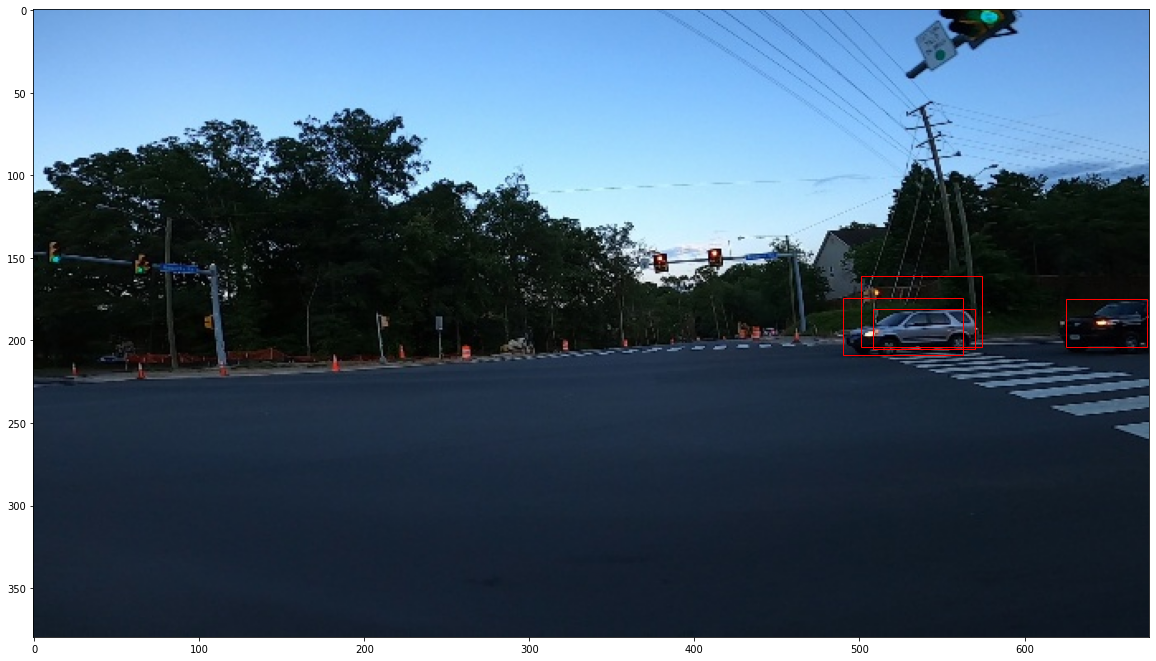

In [27]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(sample)
for box in boxes[:4]:
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()